In [ ]:
!pip install simplejson

     |████████████████████████████████| 129 kB 4.1 MB/s 


In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json
from os import listdir, mkdir
from os.path import isdir
import os
from math import ceil, isnan
from tqdm import tqdm
import simplejson 

In [ ]:
brkfst = "brkfst"
lnch = "lnch"
dnr = "dnr"

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/Shareddrives/soone/summary_data"

In [ ]:
def get_all_user_id():
    return [f[:-4] for f in listdir("/content/drive/Shareddrives/soone/user_data")]


In [ ]:
def get_meal_data(id):
    df = pd.read_csv(f"/content/drive/Shareddrives/soone/user_data/{id}.csv", encoding="cp949")
    meal_record = {"brkfst":[None for _ in range(31)], "lnch":[None for _ in range(31)], "dnr":[None for _ in range(31)]}
    df = df.dropna(subset=["Z"])
    for idx, row in df.iterrows():
        t = datetime.strptime(row["Time"][1:], "%Y-%m-%d %H:%M:%S")
        if  ( "식사 판단" in row["Z"]) and (t.hour >= 6 and t.hour <= 11): # 아침
            meal_record["brkfst"][t.day-1] = t.hour + t.minute/60

        if  ("식사 판단" in row["Z"]) and (t.hour >= 11 and t.hour <= 15): # 점심
            meal_record["lnch"][t.day-1] = t.hour + t.minute/60

        if  ("식사 판단" in row["Z"]) and (t.hour >= 16 and t.hour <= 20): # 저녁
            # print(t.day, t.hour, t.minute/60)
            meal_record["dnr"][t.day-1] = t.hour + t.minute/60

    meal_record = pd.DataFrame(meal_record)
    meal_record["count"] = meal_record.count(axis=1)
    score = meal_record["count"].mean()/3*100

    std_list = [meal_record[brkfst].dropna().std(),meal_record[lnch].dropna().std(),meal_record[dnr].dropna().std()]
    for std in std_list:
        if not isnan(std):
            score -= std
    score -= meal_record["count"].std()
    # print(meal_record["count"].std())
    return meal_record, score

In [ ]:
df, score = get_meal_data("1001")

In [ ]:
df[dnr].dropna().std()

nan

In [ ]:
score

6.762844879784293

In [ ]:
df.head()

,brkfst,lnch,dnr,count
0,11.383333,11.383333,17.450000,3
1,11.683333,14.200000,NaN,2
2,NaN,14.666667,20.083333,2
3,NaN,14.483333,19.283333,2
4,9.416667,15.516667,19.200000,3


In [ ]:
def generate_daily_record():
    user_list = get_all_user_id()
    for u in tqdm(user_list):
        meal_record, score = get_meal_data(u)
        # make dir for user data
        if not isdir(os.path.join(BASE_DIR,u)):
            mkdir(os.path.join(BASE_DIR,u))
        # make dir for user sleep data
        if not isdir(os.path.join(BASE_DIR,u, "meal")):
            mkdir(os.path.join(BASE_DIR,u, "meal"))
        meal_dir = os.path.join(BASE_DIR,u, "meal")
        daily_json_list = [[] for _ in range(ceil(31/7))]
        i = 0
        for _, row in meal_record.iterrows():
            daily_record = {}
            daily_record[brkfst], daily_record[lnch], daily_record[dnr] = \
            row[brkfst] if row[brkfst] else None, \
            row[lnch] if row[lnch] else None \
            , row[dnr] if row[dnr] else None
            daily_json_list[i//7].append(daily_record)
            i += 1
        
        f = open(os.path.join(meal_dir, "daily.json"), "w")
       
        simplejson.dump(daily_json_list, fp=f, indent=4*" ", ignore_nan=True)
        f.close()


In [ ]:
generate_daily_record()

100%|██████████| 170/170 [00:11<00:00, 14.24it/s]


In [ ]:
 get_all_user_id()[158]

'811'

In [ ]:
def generate_monthly_record():
    user_list = get_all_user_id()
    for u in tqdm(user_list):
        meal_record, score = get_meal_data(u)

        meal_dir = os.path.join(BASE_DIR,u, "meal")
        daily_json_list = [[] for _ in range(ceil(31/7))]
        
        monthly_record = {}
        avg_brkfst = meal_record[brkfst].mean()
        avg_lnch = meal_record[lnch].mean()
        avg_dnr = meal_record[dnr].mean()
        
        monthly_record["avg_brkfst"] = avg_brkfst
        monthly_record["avg_lnch"] = avg_lnch
        monthly_record["avg_dnr"] = avg_dnr
        monthly_record["score"] = score

        f = open(os.path.join(meal_dir, "monthly.json"), "w")
       
        simplejson.dump(monthly_record, fp=f, indent=4*" ", ignore_nan=True)
        f.close()

def generate_outlier():
    user_list = get_all_user_id()
    for u in tqdm(user_list):
        meal_record, score = get_meal_data(u)

        meal_dir = os.path.join(BASE_DIR,u, "meal")
        daily_json_list = [[] for _ in range(ceil(31/7))]
        
        skip_list = [[], [], []]

        for i, row in meal_record.iterrows():
            row_skip = row.isna()
            for j in range(3):
                if row_skip[j]:
                    skip_list[j].append(i+1)

        skip_record = {"brkfst":skip_list[0], "lnch":skip_list[1], "dnr":skip_list[2]}
        f = open(os.path.join(meal_dir, "outlier.json"), "w")
       
        simplejson.dump(skip_record, fp=f, indent=4*" ", ignore_nan=True)
        f.close()

In [ ]:
generate_monthly_record()
generate_outlier()

100%|██████████| 170/170 [02:10<00:00,  1.30it/s]


In [ ]:
df.iloc[1].isna()

brkfst    False
lnch      False
dnr        True
count     False
Name: 1, dtype: bool

In [ ]:
def check_score_hist():
    user_list = get_all_user_id()
    score_list = [ get_meal_data(u)[1] for u in get_all_user_id()]
    plt.hist(score_list)
    print(f"min : {min(score_list)}, max : {max(score_list)}")
    plt.show()

min : 3.349644656479509, max : 88.41554662334516


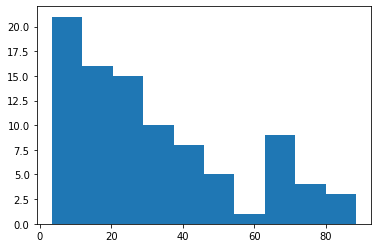

In [ ]:
check_score_hist()

In [ ]:
def generate_all_user_data():
    user_list = get_all_user_id()
    avg_brkfst_list = []
    avg_lnch_list = []
    avg_dnr_list = []
    score_list = []
    for u in tqdm(user_list):
        meal_data, score = get_meal_data(u)
        avg_brkfst = meal_data[brkfst].mean()
        avg_lnch = meal_data[lnch].mean()
        avg_dnr = meal_data[dnr].mean()

        if score:
            score_list.append(score)
        if avg_brkfst:
            avg_brkfst_list.append(avg_brkfst)
        if avg_lnch:
            avg_lnch_list.append(avg_lnch)
        if avg_dnr:
            avg_dnr_list.append(avg_dnr)
        
        # print(f"uid : {u}, b:{avg_brkfst}, l:{avg_lnch}, d:{avg_dnr}, score:{score}")
    
    avg_brkfst_list = np.array(avg_brkfst_list)
    avg_lnch_list = np.array(avg_lnch_list)
    avg_dnr_list = np.array(avg_dnr_list)
    score_list = np.array(score_list)

    all_user_data = {"avg_brkfst":avg_brkfst_list[~np.isnan(avg_brkfst_list)].mean(),
                     "avg_lnch":avg_lnch_list[~np.isnan(avg_lnch_list)].mean(),
                     "avg_dnr":avg_dnr_list[~np.isnan(avg_dnr_list)].mean(),
                     "score" : score_list[~np.isnan(score_list)].mean() 
                     }
    save_dir = os.path.join(BASE_DIR,"all_user", "meal")
    if not isdir(save_dir):
        os.mkdir(save_dir)
    f = open(os.path.join(save_dir,"all_user_average.json"), "w")
    simplejson.dump(all_user_data, fp=f, indent=4*" ", ignore_nan=True)
    f.close()




In [ ]:
generate_all_user_data()

100%|██████████| 170/170 [00:10<00:00, 16.21it/s]
